# Exposing the API

## Introduction
At its core, Shyft provides functionality through an API (Application Programming Interface). All the functionality of Shyft is available through this API.

We begin the tutorials by introducing the API as it provides the building blocks for the framework. Once you have a good understan

In [Part I](run_nea_nidelva.ipynb) of the simulation tutorials, we covered conducting a very simple simulation of an example catchment using configuration files. This is a typical use case, but assumes that you have a model well configured and ready for simulation. In practice, one is interested in working with the model, testing different configurations, and evaluating different data sources.

This is in fact a key idea of Shyft -- to make it simple to evaluate the impact of the selection of model routine on the performance of the simulation. In this notebook we walk through a lower level paradigm of working with the toolbox and using the Shyft API directly to conduct the simulations.

**This notebook is guiding through the simulation process of a catchment. The following steps are described:**
1. **Loading required python modules and setting path to SHyFT installation**
2. **Running of a Shyft simulation**
3. **Running a Shyft simulation with updated parameters**
4. **Activating the simulation only for selected catchments**
5. **Setting up different input datasets**
6. **Changing state collection settings**
7. **Post processing and extracting results**

## 1. Loading required python modules and setting path to SHyFT installation

Shyft requires a number of different modules to be loaded as part of the package. Below, we describe the required steps for loading the modules, and note that some steps are only required for the use of the jupyter notebook.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import os
import datetime as dt
import pandas as pd
from os import path
import sys
from matplotlib import pyplot as plt
from netCDF4 import Dataset

In [163]:
pwd

'/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-doc/public/notebooks/budhi_gandaki'

In [166]:
d = Dataset('/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/precipitation.nc')

In [171]:
df = xr.open_mfdataset('/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/precipitation.nc')

In [178]:
df.precipitation

<xarray.DataArray 'precipitation' (time: 262968, station: 144)>
dask.array<open_dataset-eebab84d4521fe777c973b96d1d434ceprecipitation, shape=(262968, 144), dtype=float64, chunksize=(262968, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x        (station) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    y        (station) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    z        (station) float64 dask.array<chunksize=(144,), meta=np.ndarray>
Dimensions without coordinates: station
Attributes:
    units:         mm h-1
    grid_mapping:  crs

In [170]:
d.ncattrs()

[]

### The Shyft Environment

This next step is highly specific on how and where you have installed Shyft. If you have followed the guidelines at github, and cloned the three shyft repositories: i) shyft, ii) shyft-data, and iii) shyft-doc, then you may need to tell jupyter notebooks where to find shyft. Uncomment the relevant lines below.

If you have a 'system' shyft, or used `conda install -s sigbjorn shyft` to install shyft, then you probably will want to make sure you have set the SHYFT_DATA directory correctly, as otherwise, Shyft will assume the above structure and fail. __This has to be done _before_ `import shyft`__. In that case, uncomment the relevant lines below.

**note**: it is most likely that you'll need to do one or the other.

In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
# shyft_data_path = path.abspath("../../../../shyft-data")
# if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
#     os.environ['SHYFT_DATA']=shyft_data_path
    
# it is recommended that SHYFT_DATA is set as environment variable pointing to shyft-data 

from shyft.hydrology import shyftdata_dir
    
# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# This is equivalent to the two lines below
#  shyft_path=path.abspath('../../../../shyft')
#  sys.path.insert(0,shyft_path)

In [3]:
import shyft.hydrology as api
import shyft
import shyft.time_series as sts

print(shyft.__path__)

_NamespacePath(['/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/shyft', '/uio/hume/student-u63/jacobqs/pyenv/lib/python3.10/site-packages/shyft', '/uio/hume/student-u63/jacobqs/.local/lib/python3.10/site-packages/shyft'])


## 2. A Shyft simulation

The purpose of this notebook is to demonstrate setting up a Shyft simulation using existing **repositories**. Eventually, you will want to learn to write your own repositories, but once you understand what is presented herein, you'll be well on your way to working with Shyft.

If you prefer to take a **high level** approach, you can start by looking at the [Run Nea Nidelva](simulation-yaml.ipynb) notebook. We recommend taking the time to understand the lower level functionality of Shyft, however, as it will be of value later if you want to use your own data and create your own repositories.

### Orchestration and Repositories
A core philosophy of Shyft is that "Data should live at the source". What this means, is that we prefer datasets to either remain in their original format or even come directly from the data provider. To accomplish this, we use "repositories". You can read more about repositories at the [Shyft Documentation](https://shyft.readthedocs.io/en/latest/orchestration.html).

#### Interfaces
Because it is our hope that users will create their own repositories to meet the specifications of their own datasets, we provide 'interfaces'. This is a programming concept that you may not be familiar with. The idea is that it is a basic example, or template, of how the class should work. You can use these and your own class can inherit from them, allowing you to override methods to meet your own specifications. We'll explore this as we move through this tutorial. A nice [explanation of interfaces with python is available here](http://masnun.rocks/2017/04/15/interfaces-in-python-protocols-and-abcs/).

### Initial Configuration
What is required to set up a simulation? In the following we'll package some basic information into a dictionaries that may be used to configure our simualtion. We'll start by creating a couple of dictionaries that will be used to instantiate an existing **repository** class that was created for demonstration purposes, `CFRegionModelRepository`.

If it hasn't been said enough, there is *a lot of functionality in the repositories!* You can write a repository to suit your own use case, and it is encouraged to look at this source code. 

In [4]:
# we need to import the repository to use it in a dictionary:
from shyft.hydrology.repository.netcdf.cf_region_model_repository import CFRegionModelRepository

#### region specification

The first dictionary essentially establishes the domain of the simulation. We also specify a repository that is used to read the data that will provide Shyft a `region_model` (discussed below), based on geographic data. The geographic consists of properties of the catchment, e.g. "forest fraction", "lake fraction", etc.

In [5]:
# next, create the simulation dictionary
RegionDict = {'region_model_id': 'demo', #a unique name identifier of the simulation
              'domain': {'EPSG': 32645,
                        'nx': 144,
                        'ny': 144,
                        'step_x': 51000,
                        'step_y': 54000,
                        'lower_left_x': 73528.58823297377,
                        'lower_left_y': 2854878.42464918},
              'repository': {'class': shyft.hydrology.repository.netcdf.cf_region_model_repository.CFRegionModelRepository,
                             'params': {'data_file': 'netcdf/orchestration-testdata/cell_data.nc'}},
          }

The first keys, are probably quite clear:

* `start_datetime`: a string in the format: "2013-09-01T00:00:00"
* `run_time_step`: an integer representing the time step of the simulation (in seconds), so for a daily step: 86400
* `number_of_steps`: an integer for how long the simulatoin should run: 365 (for a year long simulation)
* `region_model_id`: a string to name the simulation: 'neanidelva-ptgsk'

We also need to know *where* the simulation is taking place. This information is contained in the `domain`:

* `EPSG`: an EPSG string to identify the coordinate system
* `nx`: number of 'cells' in the x direction
* `ny`: number of 'cells' in the y direction
* `step_x`: size of cell in x direction (m)
* `step_y`: size of cell in y direction (m)
* `lower_left_x`: where (x) in the EPSG system the cells begin
* `lower_left_y`: where (y) in the EPSG system the cells begin
* `repository`: a repository that can read the file containing data for the cells (in this case it will read a netcdf file)

#### Model specification

The next dictionary provides information about the model that we would like to use in Shyft, or the 'Model Stack' as it is generally referred to. In this case, we are going to use the PTGSK model, and the rest of the dictionary provides the parameter values.

In [6]:
ModelDict = {'model_t': shyft.hydrology.pt_gs_k.PTGSKModel,  # model to construct
            'model_parameters': {
                'ae':{
                    'ae_scale_factor': 1.5},
                'gs':{
                    'calculate_iso_pot_energy': False,
                    'fast_albedo_decay_rate': 6.752787747748934,
                    'glacier_albedo': 0.4,
                    'initial_bare_ground_fraction': 0.04,
                    'max_albedo': 0.9,
                    'max_water': 0.1,
                    'min_albedo': 0.6,
                    'slow_albedo_decay_rate': 37.17325702015658,
                    'snow_cv': 0.4,
                    'tx': -0.5752881492890207,
                    'snowfall_reset_depth': 5.0,
                    'surface_magnitude': 30.0,
                    'wind_const': 1.0,
                    'wind_scale': 1.8959672005350063,
                    'winter_end_day_of_year': 100},
                'kirchner':{ 
                    'c1': -3.336197322290274,
                    'c2': 0.33433661533385695,
                    'c3': -0.12503959620315988},
                'p_corr': {
                    'scale_factor': 1.0},
                'pt':{'albedo': 0.2,
                    'alpha': 1.26},
                    }
            }               

In this dictionary we define two variables:

* `model_t`: the import path to a shyft 'model stack' class
* `model_parameters`: a dictionary containing specific parameter values for a particular model class

Specifics of the `model_parameters` dictionary will vary based on which class is used.

Okay, so far we have two dictionaries. One which provides information regarding our simulation domain, and a second which provides information on the model that we wish to run over the domain (e.g. in each of the cells). The next step, then, is to map these together and create a `region_repo` class.

This is achieved by using a repository, in this case, the `CFRegionModelRepository` we imported above.

In [7]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)

In [8]:
region_repo

### The `region_model`

<div class="alert alert-info">

**TODO:** a notebook documenting the CFRegionModelRepository

</div>

The first step in conducting a hydrologic simulation is to define the **domain of the simulation** and the **model type** which we would like to simulate. To do this we create a `region_model` object. Above we created dictionaries that contain this information, and we instantiated a class called teh `region_repo`. In this next step, we put it together so that we have a single object which we can work with "at our fingertips". You'll note above that we have pointed to a 'data_file' earlier when we defined the `RegionDict`. This data file contains all the required elements to fill the cells of our domain. The informaiton is contained in a single [netcdf file](../../../shyft-data/netcdf/orchestration-testdata/cell_data.nc)

Before we go further, let's look briefly at the contents of this file:

In [9]:
cell_data_file = os.path.join(os.environ['SHYFT_DATA'], 'netcdf/orchestration-testdata/cell_data.nc')
cell_data = Dataset(cell_data_file)
print(cell_data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): cell(9120), crs_dim(0)
    variables(dimensions): float64 forest-fraction(cell), float64 reservoir-fraction(cell), float64 lake-fraction(cell), float64 glacier-fraction(cell), float64 x(cell), float64 y(cell), float64 z(cell), float64 area(cell), int32 catchment_id(cell), int32 crs(crs_dim), float64 aspect(cell), float64 slope(cell)
    groups: 


You might be surprised to see the dimensions are 'cells', but recall that in Shyft everything is vectorized. Each 'cell' is an element within a domain, and each cell has associated variables:

* location: x, y, z
* characteristics: forest-fraction, reservoir-fraction, lake-fraction, glacier-fraction, catchment-id

We'll bring this data into our workspace via the `region_model`. Note that we have instantiated a `region_repo` class using one of the existing Shyft repositories, in this case one that was built for reading in the data as it is contained in the example [shyft-data](https://github.com/statkraft/shyft-data) netcdf files: `CFRegionModelRepository`.


Next, we'll use the `region_repo.get_region_model` method to get the `region_model`. Note the name 'demo', in this case is arbitrary. However, depending on how you create your repository, you can specify what region model to return using this string.
<div class="alert alert-info">


**note:** *you are strongly encouraged to learn how to create repositories. This particular repository is just for demonstration purposes. In practice, one may use a repository that connects directly to a GIS service, a database, or some other data sets that contain the data required for simulations.*

<div class="alert alert-warning">

**warning**: *also, please note that below we call the 'get_region_model' method as we instantiate the class. This behavior may change in the future.*

</div>
</div>

# More about CFRegionModelRepository

In [10]:
# This file is part of Shyft. Copyright 2015-2018 SiH, JFB, OS, YAS, Statkraft AS
# See file COPYING for more details **/

"""
Read region netCDF files with cell data.

"""

from os import path
import numpy as np
from netCDF4 import Dataset
from shyft.hydrology.repository import interfaces
from typing import Union

from shapely.geometry import Polygon, MultiPolygon, box
from shapely.ops import transform
import re

from shyft.hydrology import shyftdata_dir
from shyft.hydrology.orchestration.configuration.config_interfaces import RegionConfig, ModelConfig, RegionConfigError
from shyft.hydrology.orchestration.configuration.dict_configs import DictModelConfig, DictRegionConfig
from shyft.hydrology.repository.netcdf.utils import create_ncfile, make_proj, make_transform

class CFRegionModelRepositoryError(Exception):
    pass


class CFRegionModelRepository(interfaces.RegionModelRepository):
    """
    Repository that delivers fully specified shyft api region_models
    based on data found in netcdf files.
    """

    def __init__(self, region, model):
        """
        Parameters
        ----------
        region: either a dictionary suitable to be instantiated as a
            RegionConfig Object or a sublcass of the interface RegionConfig
            containing regional information, like
            catchment overrides, and which netcdf file to read
        model: either a dictionary suitable to be instantiated as a
            ModelConfig Object or a subclass of interface ModelConfig
            Object containing model information, i.e.
            information concerning interpolation and model
            parameters
        """

        if not isinstance(region, RegionConfig):
            region_config = DictRegionConfig(region)
        if not isinstance(model, ModelConfig):
            model_config = DictModelConfig(model)
        else:
            region_config = region
            model_config = model

        if not isinstance(region_config, RegionConfig) or \
                not isinstance(model_config, ModelConfig):
            raise interfaces.InterfaceError()
        self._rconf = region_config
        self._mconf = model_config
        self._region_model = model_config.model_type()  # region_model
        self._mask = None
        self._epsg = self._rconf.domain()["EPSG"]  # epsg
        filename = self._rconf.repository()["params"]["data_file"]
        filename = path.expandvars(filename)
        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFRegionModelRepositoryError("No such file '{}'".format(filename))
        self._data_file = filename
        self._catch_ids = self._rconf.catchments()
        self.bounding_box = None



In [11]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)

In [12]:
print('From __init___:\n')
print(region_repo._rconf)
print(region_repo._mconf)
print(region_repo._mask)
print(region_repo._epsg)
print(region_repo._data_file)
print(region_repo._catch_ids)

From __init___:

None
32645
/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/cell_data.nc
None


In [13]:
import xarray as xr
ds = xr.open_mfdataset('/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/cell_data.nc')
ds.area

<xarray.DataArray 'area' (cell: 9120)>
dask.array<open_dataset-e526950effdbf3e6684e930a3c4900d3area, shape=(9120,), dtype=float64, chunksize=(9120,), chunktype=numpy.ndarray>
Coordinates:
    x        (cell) float64 dask.array<chunksize=(9120,), meta=np.ndarray>
    y        (cell) float64 dask.array<chunksize=(9120,), meta=np.ndarray>
    z        (cell) float64 dask.array<chunksize=(9120,), meta=np.ndarray>
Dimensions without coordinates: cell
Attributes:
    units:         m^2
    grid_mapping:  crs

In [14]:
class CFRegionModelRepository(interfaces.RegionModelRepository):
    """
    Repository that delivers fully specified shyft api region_models
    based on data found in netcdf files.
    """

    def __init__(self, region, model):
        """
        Parameters
        ----------
        region: either a dictionary suitable to be instantiated as a
            RegionConfig Object or a sublcass of the interface RegionConfig
            containing regional information, like
            catchment overrides, and which netcdf file to read
        model: either a dictionary suitable to be instantiated as a
            ModelConfig Object or a subclass of interface ModelConfig
            Object containing model information, i.e.
            information concerning interpolation and model
            parameters
        """

        if not isinstance(region, RegionConfig):
            region_config = DictRegionConfig(region)
        if not isinstance(model, ModelConfig):
            model_config = DictModelConfig(model)
        else:
            region_config = region
            model_config = model

        if not isinstance(region_config, RegionConfig) or \
                not isinstance(model_config, ModelConfig):
            raise interfaces.InterfaceError()
        self._rconf = region_config
        self._mconf = model_config
        self._region_model = model_config.model_type()  # region_model
        self._mask = None
        self._epsg = self._rconf.domain()["EPSG"]  # epsg
        filename = self._rconf.repository()["params"]["data_file"]
        filename = path.expandvars(filename)
        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFRegionModelRepositoryError("No such file '{}'".format(filename))
        self._data_file = filename
        self._catch_ids = self._rconf.catchments()
        self.bounding_box = None

    def get_region_model(self, region_id, catchments=None):
        """
        Return a fully specified shyft api region_model for region_id, based on data found
        in netcdf dataset.

        Parameters
        -----------
        region_id: string
            unique identifier of region in data

        catchments: list of unique integers
            catchment indices when extracting a region consisting of a subset
            of the catchments has attribs to construct params and cells etc.

        Returns
        -------
        region_model: shyft.hydrology type
        """

        with Dataset(self._data_file) as dset:
            Vars = dset.variables
            c_ids = Vars["catchment_id"][:]
            xcoord = Vars['x'][:]
            ycoord = Vars['y'][:]
            m_catch = np.ones(len(c_ids), dtype=bool)
            if self._catch_ids is not None:
                m_catch = np.in1d(c_ids, self._catch_ids)
                xcoord_m = xcoord[m_catch]
                ycoord_m = ycoord[m_catch]
                
            dataset_epsg = None
            if 'crs' in Vars.keys():
                dataset_epsg = Vars['crs'].epsg_code.split(':')[1]
            if not dataset_epsg:
                raise interfaces.InterfaceError("netcdf: epsg attr not found in group elevation")

            target_cs = "+init=EPSG:{}".format(self._epsg)
            source_cs = "+init=EPSG:{}".format(dataset_epsg)
            # Construct bounding region
            box_fields = set(("lower_left_x", "lower_left_y", "step_x", "step_y", "nx", "ny", "EPSG"))
            if box_fields.issubset(self._rconf.domain()):
                tmp = self._rconf.domain()
                epsg = tmp["EPSG"]
                x_min = tmp["lower_left_x"]
                x_max = x_min + tmp["nx"]*tmp["step_x"]
                y_min = tmp["lower_left_y"]
                y_max = y_min + tmp["ny"]*tmp["step_y"]

            print('Vars: \n', Vars)
            print('\n c_ids: \n\n', c_ids)
            print('\n xcoord: \n\n', xcoord)
            print('\n ycoord: \n\n', ycoord)
            print('\n m_catch: \n\n', m_catch)
            print('\n dataset_epsg: \n\n', dataset_epsg)
            print('\n target_crs: \n', target_cs)
            print('\n source_crs: \n', source_cs)
            print('\n box_fields: \n', box_fields)
            print('\n temp: \n', tmp)
            print('\n epsg: \n', epsg)
            print('\n x_min: \n', x_min)
            print('\n x_max: \n', x_max)
            print('\n y_min: \n', y_min)
            print('\n y_max: \n', y_max)

In [15]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)
region_repo.get_region_model('demo')

Vars: 
 {'forest-fraction': <class 'netCDF4._netCDF4.Variable'>
float64 forest-fraction(cell)
    units: -
    grid_mapping: crs
    coordinates: y x z
unlimited dimensions: 
current shape = (9120,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'reservoir-fraction': <class 'netCDF4._netCDF4.Variable'>
float64 reservoir-fraction(cell)
    units: -
    grid_mapping: crs
    coordinates: y x z
unlimited dimensions: 
current shape = (9120,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lake-fraction': <class 'netCDF4._netCDF4.Variable'>
float64 lake-fraction(cell)
    units: -
    grid_mapping: crs
    coordinates: y x z
unlimited dimensions: 
current shape = (9120,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'glacier-fraction': <class 'netCDF4._netCDF4.Variable'>
float64 glacier-fraction(cell)
    units: -
    grid_mapping: crs
    coordinates: y x z
unlimited dimensions: 
current shape = (9120,)
filling on, default _FillValue of 9.96920

### The next step in this repository is to create bounding box region using the BoundingBoxRegion class:

In [16]:
class BoundingBoxRegion(interfaces.BoundingRegion):

    def __init__(self, x, y, point_epsg, target_epsg):
        self._epsg = str(point_epsg)
        x_min = x.ravel().min()
        x_max = x.ravel().max()
        y_min = y.ravel().min()
        y_max = y.ravel().max()
        self.x = np.array([x_min, x_max, x_max, x_min], dtype="d")
        self.y = np.array([y_min, y_min, y_max, y_max], dtype="d")
        self.x, self.y = self.bounding_box(target_epsg)
        self._epsg = str(target_epsg)
        self._polygon = box(x_min, y_min, x_max, y_max)

    def bounding_box(self, epsg):
        epsg = str(epsg)
        if epsg == self.epsg():
            return np.array(self.x), np.array(self.y)
        else:
            source_cs = "+init=EPSG:{}".format(self.epsg())
            target_cs = "+init=EPSG:{}".format(epsg)
            source_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", source_cs)  # TODO: remove this workaround when Proj allows for +e=0
            target_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
            source_proj = make_proj(source_cs)
            target_proj = make_proj(target_cs)
            fx = make_transform(source_proj, target_proj)
            return [np.array(a) for a in fx(self.x, self.y)]

    def bounding_polygon(self, epsg: int) -> Union[Polygon, MultiPolygon]:
        """Implementation of interface.BoundingRegion"""
        if epsg == self.epsg():
            return self._polygon
        else:
            source_cs = "+init=EPSG:{}".format(self.epsg())
            target_cs = "+init=EPSG:{}".format(epsg)
            source_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", source_cs)  # TODO: remove this workaround when Proj allows for +e=0
            target_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
            source_proj = make_proj(source_cs)
            target_proj = make_proj(target_cs)
            project = make_transform(source_proj, target_proj)
            return transform(project, self._polygon)

    def epsg(self):
        return self._epsg


In [17]:
bounding_region = BoundingBoxRegion(np.array([73528.58823297377,  217528.58823297377]), 
                                    np.array([2854878.42464918, 2998878.42464918]), 32645, 32645)

In [18]:
bounding_region.__dict__

{'_epsg': '32645',
 'x': array([ 73528.58823297, 217528.58823297, 217528.58823297,  73528.58823297]),
 'y': array([2854878.42464918, 2854878.42464918, 2998878.42464918,
        2998878.42464918]),
 '_polygon': <shapely.geometry.polygon.Polygon at 0x7f243dd6f730>}

In [19]:
bounding_region.bounding_box(32645)

(array([ 73528.58823297, 217528.58823297, 217528.58823297,  73528.58823297]),
 array([2854878.42464918, 2854878.42464918, 2998878.42464918,
        2998878.42464918]))

In [20]:
class CFRegionModelRepository(interfaces.RegionModelRepository):
    """
    Repository that delivers fully specified shyft api region_models
    based on data found in netcdf files.
    """

    def __init__(self, region, model):
        """
        Parameters
        ----------
        region: either a dictionary suitable to be instantiated as a
            RegionConfig Object or a sublcass of the interface RegionConfig
            containing regional information, like
            catchment overrides, and which netcdf file to read
        model: either a dictionary suitable to be instantiated as a
            ModelConfig Object or a subclass of interface ModelConfig
            Object containing model information, i.e.
            information concerning interpolation and model
            parameters
        """

        if not isinstance(region, RegionConfig):
            region_config = DictRegionConfig(region)
        if not isinstance(model, ModelConfig):
            model_config = DictModelConfig(model)
        else:
            region_config = region
            model_config = model

        if not isinstance(region_config, RegionConfig) or \
                not isinstance(model_config, ModelConfig):
            raise interfaces.InterfaceError()
        self._rconf = region_config
        self._mconf = model_config
        self._region_model = model_config.model_type()  # region_model
        self._mask = None
        self._epsg = self._rconf.domain()["EPSG"]  # epsg
        filename = self._rconf.repository()["params"]["data_file"]
        filename = path.expandvars(filename)
        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFRegionModelRepositoryError("No such file '{}'".format(filename))
        self._data_file = filename
        self._catch_ids = self._rconf.catchments()
        self.bounding_box = None
    
    def _limit(self, x, y, data_cs, target_cs):
        """
        Parameters
        ----------
        """
        # Get coordinate system for arome data
        data_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", data_cs)  # TODO: remove this workaround when Proj allows for +e=0
        target_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
        data_proj = make_proj(data_cs_)
        target_proj = make_proj(target_cs_)

        # Find bounding box in arome projection
        bbox = self.bounding_box
        bb_proj = make_transform(target_proj, data_proj)(bbox[0], bbox[1])
        x_min, x_max = min(bb_proj[0]), max(bb_proj[0])
        y_min, y_max = min(bb_proj[1]), max(bb_proj[1])

        # Limit data
        xy_mask = ((x <= x_max) & (x >= x_min) & (y <= y_max) & (y >= y_min))

        xy_inds = np.nonzero(xy_mask)[0]

        # Transform from source coordinates to target coordinates
        xx, yy = make_transform(data_proj, target_proj)(x, y)
        
        print('data_cs: \n', data_cs)
        print('target_cs: \n', target_cs)
        print('data_proj: \n', data_proj)
        print('target_proj: \n', target_proj)
        print('bbox: \n', bbox)
        print('bb_proj: \n', bb_proj)
        print('x_min, x_max: \n', x_min, x_max)
        print('y_min, y_max: \n', y_min, y_max)
        print('xy_mask: \n', xy_mask)
        print('xy_inds: \n', xy_inds)
        print('xx: \n', xx)
        print('yy: \n', yy)

        return xx, yy, xy_mask, xy_inds


    def get_region_model(self, region_id, catchments=None):
        """
        Return a fully specified shyft api region_model for region_id, based on data found
        in netcdf dataset.

        Parameters
        -----------
        region_id: string
            unique identifier of region in data

        catchments: list of unique integers
            catchment indices when extracting a region consisting of a subset
            of the catchments has attribs to construct params and cells etc.

        Returns
        -------
        region_model: shyft.hydrology type
        """

        with Dataset(self._data_file) as dset:
            Vars = dset.variables
            c_ids = Vars["catchment_id"][:]
            xcoord = Vars['x'][:]
            ycoord = Vars['y'][:]
            m_catch = np.ones(len(c_ids), dtype=bool)
            if self._catch_ids is not None:
                m_catch = np.in1d(c_ids, self._catch_ids)
                xcoord_m = xcoord[m_catch]
                ycoord_m = ycoord[m_catch]
                
            dataset_epsg = None
            if 'crs' in Vars.keys():
                dataset_epsg = Vars['crs'].epsg_code.split(':')[1]
            if not dataset_epsg:
                raise interfaces.InterfaceError("netcdf: epsg attr not found in group elevation")

            target_cs = "+init=EPSG:{}".format(self._epsg)
            source_cs = "+init=EPSG:{}".format(dataset_epsg)
            
            # Construct bounding region
            box_fields = set(("lower_left_x", "lower_left_y", "step_x", "step_y", "nx", "ny", "EPSG"))
            if box_fields.issubset(self._rconf.domain()):
                tmp = self._rconf.domain()
                epsg = tmp["EPSG"]
                x_min = tmp["lower_left_x"]
                x_max = x_min + tmp["nx"]*tmp["step_x"]
                y_min = tmp["lower_left_y"]
                y_max = y_min + tmp["ny"]*tmp["step_y"]
                bounding_region = BoundingBoxRegion(np.array([x_min, x_max]),
                                                    np.array([y_min, y_max]), epsg, self._epsg)
            else:
                bounding_region = BoundingBoxRegion(xcoord_m, ycoord_m, dataset_epsg, self._epsg)
            self.bounding_box = bounding_region.bounding_box(self._epsg)
            x, y, m_xy, _ = self._limit(xcoord, ycoord, source_cs, target_cs)
            
            mask = (m_xy & m_catch)

            areas = Vars['area'][mask]
            elevation = Vars["z"][mask]
            coordinates = np.dstack((x[mask], y[mask], elevation)).reshape(-1, 3)

            c_ids = Vars["catchment_id"][mask]
            c_ids_unique = list(np.unique(c_ids))
            # c_indx = np.array([c_ids_unique.index(cid) for cid in c_ids]) # since ID to Index conversion not necessary

            ff = Vars["forest-fraction"][mask]
            lf = Vars["lake-fraction"][mask]
            rf = Vars["reservoir-fraction"][mask]
            gf = Vars["glacier-fraction"][mask]

            print('\nx: \n', x)
            print('\ny: \n', y)
            print('\nm_xy: \n', m_xy)
            print('\nmask: \n', mask)
            print('\nareas: \n', areas)
            print('\nelevation: \n', elevation)
            print('\ncoordinates: \n', coordinates)
            print('\nc_ids: \n', c_ids)
            print('\nc_ids_unique: \n', c_ids_unique)
            print('\nff: \n', ff)
            print('\nlf: \n', lf)
            print('\ngf: \n', gf)

In [21]:
# Limit data
x = ds.x.values
y = ds.y.values
print(x)
print(y)
x_min = 73528.58823297377
x_max = 217528.58823297377
y_min = 2854878.42464918
y_max = 2998878.42464918
xy_mask = ((x <= x_max) & (x >= x_min) & (y <= y_max) & (y >= y_min))


[232130.21073515 232750.53445001 236025.91525004 ... 155311.09377058
 157110.42765339 158386.03330917]
[3093314.16461738 3093409.90881549 3093533.79623862 ... 3138533.25089299
 3138694.72916582 3139113.3337486 ]


In [22]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)
region_repo.get_region_model('demo')

data_cs: 
 +init=EPSG:32645
target_cs: 
 +init=EPSG:32645
data_proj: 
 proj=utm zone=45 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
target_proj: 
 proj=utm zone=45 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
bbox: 
 (array([  73528.58823297, 7417528.58823297, 7417528.58823297,
         73528.58823297]), array([ 2854878.42464918,  2854878.42464918, 10630878.42464918,
       10630878.42464918]))
bb_proj: 
 (array([  73528.58823297, 7417528.58823297, 7417528.58823297,
         73528.58823297]), array([ 2854878.42464918,  2854878.42464918, 10630878.42464918,
       10630878.42464918]))
x_min, x_max: 
 73528.58823297377 7417528.588232974
y_min, y_max: 
 2854878.42464918 10630878.424649179
xy_mask: 
 [ True  True  True ...  True  True  True]
xy_inds: 
 [   0    1    2 ... 9117 9118 9119]
xx: 
 [232130.21073515 232750.53445001 236025.91525004 ... 155311.09377058
 157110.42765339 158386.03330917]
yy: 
 [3093314.16461738 3093409.90881549 3093533.79623862 ... 3138533.25089299

In [23]:
region_model = region_repo.get_region_model('demo')

data_cs: 
 +init=EPSG:32645
target_cs: 
 +init=EPSG:32645
data_proj: 
 proj=utm zone=45 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
target_proj: 
 proj=utm zone=45 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
bbox: 
 (array([  73528.58823297, 7417528.58823297, 7417528.58823297,
         73528.58823297]), array([ 2854878.42464918,  2854878.42464918, 10630878.42464918,
       10630878.42464918]))
bb_proj: 
 (array([  73528.58823297, 7417528.58823297, 7417528.58823297,
         73528.58823297]), array([ 2854878.42464918,  2854878.42464918, 10630878.42464918,
       10630878.42464918]))
x_min, x_max: 
 73528.58823297377 7417528.588232974
y_min, y_max: 
 2854878.42464918 10630878.424649179
xy_mask: 
 [ True  True  True ...  True  True  True]
xy_inds: 
 [   0    1    2 ... 9117 9118 9119]
xx: 
 [232130.21073515 232750.53445001 236025.91525004 ... 155311.09377058
 157110.42765339 158386.03330917]
yy: 
 [3093314.16461738 3093409.90881549 3093533.79623862 ... 3138533.25089299

## Implementing everything

In [24]:
class CFRegionModelRepositoryError(Exception):
    pass


class CFRegionModelRepository(interfaces.RegionModelRepository):
    """
    Repository that delivers fully specified shyft api region_models
    based on data found in netcdf files.
    """

    def __init__(self, region, model):
        """
        Parameters
        ----------
        region: either a dictionary suitable to be instantiated as a
            RegionConfig Object or a sublcass of the interface RegionConfig
            containing regional information, like
            catchment overrides, and which netcdf file to read
        model: either a dictionary suitable to be instantiated as a
            ModelConfig Object or a subclass of interface ModelConfig
            Object containing model information, i.e.
            information concerning interpolation and model
            parameters
        """

        if not isinstance(region, RegionConfig):
            region_config = DictRegionConfig(region)
        if not isinstance(model, ModelConfig):
            model_config = DictModelConfig(model)
        else:
            region_config = region
            model_config = model

        if not isinstance(region_config, RegionConfig) or \
                not isinstance(model_config, ModelConfig):
            raise interfaces.InterfaceError()
        self._rconf = region_config
        self._mconf = model_config
        self._region_model = model_config.model_type()  # region_model
        self._mask = None
        self._epsg = self._rconf.domain()["EPSG"]  # epsg
        filename = self._rconf.repository()["params"]["data_file"]
        filename = path.expandvars(filename)
        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFRegionModelRepositoryError("No such file '{}'".format(filename))
        self._data_file = filename
        self._catch_ids = self._rconf.catchments()
        self.bounding_box = None

    def _limit(self, x, y, data_cs, target_cs):
        """
        Parameters
        ----------
        """
        # Get coordinate system for arome data
        data_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", data_cs)  # TODO: remove this workaround when Proj allows for +e=0
        target_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
        data_proj = make_proj(data_cs_)
        target_proj = make_proj(target_cs_)

        # Find bounding box in arome projection
        bbox = self.bounding_box
        bb_proj = make_transform(target_proj, data_proj)(bbox[0], bbox[1])
        x_min, x_max = min(bb_proj[0]), max(bb_proj[0])
        y_min, y_max = min(bb_proj[1]), max(bb_proj[1])

        # Limit data
        xy_mask = ((x <= x_max) & (x >= x_min) & (y <= y_max) & (y >= y_min))

        xy_inds = np.nonzero(xy_mask)[0]

        # Transform from source coordinates to target coordinates
        xx, yy = make_transform(data_proj, target_proj)(x, y)

        return xx, yy, xy_mask, xy_inds

    def get_region_model(self, region_id, catchments=None):
        """
        Return a fully specified shyft api region_model for region_id, based on data found
        in netcdf dataset.

        Parameters
        -----------
        region_id: string
            unique identifier of region in data

        catchments: list of unique integers
            catchment indices when extracting a region consisting of a subset
            of the catchments has attribs to construct params and cells etc.

        Returns
        -------
        region_model: shyft.hydrology type
        """

        with Dataset(self._data_file) as dset:
            Vars = dset.variables
            c_ids = Vars["catchment_id"][:]
            xcoord = Vars['x'][:]
            ycoord = Vars['y'][:]
            m_catch = np.ones(len(c_ids), dtype=bool)
            if self._catch_ids is not None:
                m_catch = np.in1d(c_ids, self._catch_ids)
                xcoord_m = xcoord[m_catch]
                ycoord_m = ycoord[m_catch]

            dataset_epsg = None
            if 'crs' in Vars.keys():
                dataset_epsg = Vars['crs'].epsg_code.split(':')[1]
            if not dataset_epsg:
                raise interfaces.InterfaceError("netcdf: epsg attr not found in group elevation")

            target_cs = "+init=EPSG:{}".format(self._epsg)
            source_cs = "+init=EPSG:{}".format(dataset_epsg)

            # Construct bounding region
            box_fields = set(("lower_left_x", "lower_left_y", "step_x", "step_y", "nx", "ny", "EPSG"))
            if box_fields.issubset(self._rconf.domain()):
                tmp = self._rconf.domain()
                epsg = tmp["EPSG"]
                x_min = tmp["lower_left_x"]
                x_max = x_min + tmp["nx"]*tmp["step_x"]
                y_min = tmp["lower_left_y"]
                y_max = y_min + tmp["ny"]*tmp["step_y"]
                bounding_region = BoundingBoxRegion(np.array([x_min, x_max]),
                                                    np.array([y_min, y_max]), epsg, self._epsg)
            else:
                bounding_region = BoundingBoxRegion(xcoord_m, ycoord_m, dataset_epsg, self._epsg)
            self.bounding_box = bounding_region.bounding_box(self._epsg)
            x, y, m_xy, _ = self._limit(xcoord, ycoord, source_cs, target_cs)

            mask = (m_xy & m_catch)

            areas = Vars['area'][mask]
            elevation = Vars["z"][mask]
            coordinates = np.dstack((x[mask], y[mask], elevation)).reshape(-1, 3)

            c_ids = Vars["catchment_id"][mask]
            c_ids_unique = list(np.unique(c_ids))
            # c_indx = np.array([c_ids_unique.index(cid) for cid in c_ids]) # since ID to Index conversion not necessary

            ff = Vars["forest-fraction"][mask]
            lf = Vars["lake-fraction"][mask]
            rf = Vars["reservoir-fraction"][mask]
            gf = Vars["glacier-fraction"][mask]

        # Construct region parameter:
        region_parameter = self._region_model.parameter_t()
        for p_type_name, value_ in self._mconf.model_parameters().items():
            if hasattr(region_parameter, p_type_name):
                sub_param = getattr(region_parameter, p_type_name)
                for p, v in value_.items():
                    if hasattr(sub_param, p):
                        setattr(sub_param, p, v)
                    else:
                        raise RegionConfigError("Invalid parameter '{}' for parameter set '{}'".format(p, p_type_name))
            else:
                raise RegionConfigError("Invalid parameter set '{}' for selected model '{}'".format(p_type_name, self._region_model.__name__))

        radiation_slope_factor = 0.9  # TODO: Move into yaml file similar to p_corr_scale_factor
        unknown_fraction = 1.0 - gf - lf - rf - ff

        # Construct cells
        cell_geo_data = np.column_stack([x[mask], y[mask], elevation, areas, c_ids.astype(int), np.full(len(c_ids),
                                                                                                        radiation_slope_factor), gf, lf, rf, ff, unknown_fraction])
        cell_vector = self._region_model.cell_t.vector_t.create_from_geo_cell_data_vector(np.ravel(cell_geo_data))
        for c in cell_vector:  # ensure we propagate the epsg_id to all cells
            c.geo.epsg_id = int(self._epsg)
        # Construct catchment overrides
        catchment_parameters = self._region_model.parameter_t.map_t()
        for cid, catch_param in self._rconf.parameter_overrides().items():
            if cid in c_ids_unique:
                param = self._region_model.parameter_t(region_parameter)
                for p_type_name, value_ in catch_param.items():
                    if hasattr(param, p_type_name):
                        sub_param = getattr(param, p_type_name)
                        for p, v in value_.items():
                            if hasattr(sub_param, p):
                                setattr(sub_param, p, v)
                            else:
                                raise RegionConfigError("Invalid parameter '{}' for catchment parameter set '{}'".format(p, p_type_name))
                    else:
                        raise RegionConfigError("Invalid catchment parameter set '{}' for selected model '{}'".format(p_type_name, self._region_model.__name__))

                catchment_parameters[cid] = param
        region_model = self._region_model(cell_vector, region_parameter, catchment_parameters)
        region_model.bounding_region = bounding_region
        region_model.catchment_id_map = c_ids_unique

        def do_clone(x):
            clone = x.__class__(x)
            clone.bounding_region = x.bounding_region
            clone.catchment_id_map = x.catchment_id_map
            # clone.gis_info = polygons  # cell shapes not included yet
            return clone

        region_model.clone = do_clone
        return region_model

    def cell_data_to_netcdf(self, region_model, output_dir):
        """
        Writes cell_data from a shyft region_model in the same format the
         'cf_region_model_repository' expects.

        Parameters
        -----------
        region_model: shyft.region_model

        output_dir: path to where to store netcdf file

        Returns
        -------


        """

        nc_file = "{}_cell_data.nc".format(output_dir)
        # repository = {'class': self.__class__,
        #               'params': {'data_file': nc_file}
        #               }

        # with open('{}.yaml'.format(nc_file), 'w') as yml:
        #     yaml.dump(repository, yml)

        dimensions = {'cell': len(region_model.cells)}

        variables = {'y': [float, ('cell',), {'axis': 'Y',
                                                 'units': 'm',
                                                 'standard_name': 'projection_y_coordinate'}],

                     'x': [float, ('cell',), {'axis': 'X',
                                                 'units': 'm',
                                                 'standard_name': 'projection_x_coordinate'}],

                     'z': [float, ('cell',), {'axis': 'Z',
                                                 'units': 'm',
                                                 'standard_name': 'height',
                                                 'long_name': 'height above mean sea level'}],

                     'crs': [np.int32, ('cell',), {'grid_mapping_name': 'transverse_mercator',
                                                   'epsg_code': 'EPSG:' + str(region_model.bounding_region.epsg()),
                                                   'proj4': "+proj = utm + zone = 33 + ellps = WGS84 + datum = WGS84 + units = m + no_defs"}],

                     'area': [float, ('cell',), {'grid_mapping': 'crs',
                                                    'units': 'm^2',
                                                    'coordinates': 'y x z'}],

                     'forest-fraction': [float, ('cell',), {'grid_mapping': 'crs',
                                                               'units': '-',
                                                               'coordinates': 'y x z'}],

                     'glacier-fraction': [float, ('cell',), {'grid_mapping': 'crs',
                                                                'units': '-',
                                                                'coordinates': 'y x z'}],

                     'lake-fraction': [float, ('cell',), {'grid_mapping': 'crs',
                                                             'units': '-',
                                                             'coordinates': 'y x z'}],

                     'reservoir-fraction': [float, ('cell',), {'grid_mapping': 'crs',
                                                                  'units': '-',
                                                                  'coordinates': 'y x z'}],

                     'catchment_id': [np.int32, ('cell',), {'grid_mapping': 'crs',
                                                            'units': '-',
                                                            'coordinates': 'y x z'}],
                     }

        create_ncfile(nc_file, variables, dimensions)
        nci = Dataset(nc_file, 'a')

        extracted_geo_cell_data = region_model.extract_geo_cell_data()
        nci.variables['x'][:] = [gcd.mid_point().x for gcd in extracted_geo_cell_data]
        nci.variables['y'][:] = [gcd.mid_point().y for gcd in extracted_geo_cell_data]
        nci.variables['z'][:] = [gcd.mid_point().z for gcd in extracted_geo_cell_data]
        nci.variables['area'][:] = [gcd.area() for gcd in extracted_geo_cell_data]
        nci.variables['crs'][:] = [len(region_model.cells)*[region_model.bounding_region.epsg()]]
        nci.variables['catchment_id'][:] = [gcd.catchment_id() for gcd in extracted_geo_cell_data]
        nci.variables['lake-fraction'][:] = [gcd.land_type_fractions_info().lake() for gcd in extracted_geo_cell_data]
        nci.variables['reservoir-fraction'][:] = [gcd.land_type_fractions_info().reservoir() for gcd in extracted_geo_cell_data]
        nci.variables['glacier-fraction'][:] = [gcd.land_type_fractions_info().glacier() for gcd in extracted_geo_cell_data]
        nci.variables['forest-fraction'][:] = [gcd.land_type_fractions_info().forest() for gcd in extracted_geo_cell_data]

        nci.close()


class BoundingBoxRegion(interfaces.BoundingRegion):

    def __init__(self, x, y, point_epsg, target_epsg):
        self._epsg = str(point_epsg)
        x_min = x.ravel().min()
        x_max = x.ravel().max()
        y_min = y.ravel().min()
        y_max = y.ravel().max()
        self.x = np.array([x_min, x_max, x_max, x_min], dtype="d")
        self.y = np.array([y_min, y_min, y_max, y_max], dtype="d")
        self.x, self.y = self.bounding_box(target_epsg)
        self._epsg = str(target_epsg)
        self._polygon = box(x_min, y_min, x_max, y_max)

    def bounding_box(self, epsg):
        epsg = str(epsg)
        if epsg == self.epsg():
            return np.array(self.x), np.array(self.y)
        else:
            source_cs = "+init=EPSG:{}".format(self.epsg())
            target_cs = "+init=EPSG:{}".format(epsg)
            source_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", source_cs)  # TODO: remove this workaround when Proj allows for +e=0
            target_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
            source_proj = make_proj(source_cs)
            target_proj = make_proj(target_cs)
            fx = make_transform(source_proj, target_proj)
            return [np.array(a) for a in fx(self.x, self.y)]

    def bounding_polygon(self, epsg: int) -> Union[Polygon, MultiPolygon]:
        """Implementation of interface.BoundingRegion"""
        if epsg == self.epsg():
            return self._polygon
        else:
            source_cs = "+init=EPSG:{}".format(self.epsg())
            target_cs = "+init=EPSG:{}".format(epsg)
            source_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", source_cs)  # TODO: remove this workaround when Proj allows for +e=0
            target_cs = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs)
            source_proj = make_proj(source_cs)
            target_proj = make_proj(target_cs)
            project = make_transform(source_proj, target_proj)
            return transform(project, self._polygon)

    def epsg(self):
        return self._epsg


In [25]:
region_repo = CFRegionModelRepository(RegionDict, ModelDict)
region_model = region_repo.get_region_model('demo')

#### Exploring the `region_model`

So we now have created a `region_model`, but what is it actually? This is a very **fundamental class** in Shyft. It is actually one of the "model stacks", such as 'PTGSK', or 'PTHSK'. Essentially, the `region_model` contains all the information regarding the simulation type and domain. There are many methods associated with the `region_model` and it will take time to understand all of them. For now, let's just explore a few key methods:

* `bounding_region`: provides information regarding the domain of interest for the simulation
* `catchment_id_map`: indices of the various catchments within the domain
* `cells`: an instance of `PTGSKCellAllVector` that holds the individual cells for the simulation (*note that this is type-specific to the model type*)
* `ncore`: an integer that sets the numbers of cores to use during simulation (Shyft is very greedy if you let it!)
* `time_axis`: a `shyft.api.TimeAxisFixedDeltaT` class (basically contains information regarding the timing of the simulation)

Keep in mind that many of these methods are more 'C++'-like than 'Pythonic'. This means, that in some cases, you'll have to 'call' the method. For example: `region_model.bounding_region.epsg()` returns a string. You can use tab-completion to explore the `region_model` further:

In [26]:
region_model.bounding_region.epsg()

'32645'

You'll likely note that there are a number of intriguing fucntions, e.g. `initialize_cell_environment` or `interpolate`. But before we can go further, we need some more information. Perhaps you are wondering about forcing data. So far, we haven't said anything about **model input** or the **time** of the simulation, we've only set up a container that holds all the domain and model type information about our simulation. 

Still, we have made *some* progress. Let's look for instance at the cells:

In [27]:
cell_0 = region_model.cells[0]
print(cell_0.geo)

GeoCellData(mid_point=GeoPoint(232130.21073514555,3093314.1646173806,453.3),catchment_id=1,area=85959.772,ltf=LandTypeFractions(glacier=0.0,lake=0.0,reservoir=0.0,forest=1.0,unspecified=0.0))


So you can see that so far, each of the cells in the region_model contain information regarding their LandTypeFractions, geolocation, catchment_id, and area. 

A particulary important attribute is `region_model.region_env`. This is a container for each cell that holds the "environmental timeseries", or forcing data, for the simulation. By "tabbing" from `cell.` you can see that each cell also has and `env_ts` attribute. These are containers customized to provide timeseries as required by the model type we selected, but there is no data yet. In this case we used the `PTGSKModel` (see the `ModelDict`). So for every cell in your simulation, there is a container prepared to accept the forcing data as the next cell shows.

In [28]:
#just so we don't see 'private' attributes
print([d for d  in dir(cell_0.env_ts) if  '_'  not in d[0]]) 
region_model.size()

['has_nan_values', 'init', 'precipitation', 'radiation', 'rel_hum', 'temperature', 'wind_speed']


9120

### Adding forcing data to the `region_model`

Clearly the next step is to add forcing data to our `region_model` object. Let's start by thinking about what kind of data we need. From above, where we looked at the `env_ts` attribute, it's clear that this particular model stack, `PTGSKModel`, requires:

* precipitation
* radiation
* relative humidity (rel_hum)
* temperature
* wind speed

We have stored this information each in seperate netcdf files which each contain the observational series for a number of different stations. 

<div class="alert alert-warning">

Again, these files **do not represent the recommended practice**, but are *only for demonstration purposes*. The idea here is just to demonstrate with an example repository, but *you should create your own to match **your** data*.

</div>

Our goal now is to populate the `region_env`. 

#### "Sources"

We use the term *sources* to define a location data may be coming from. You may also come across *destinations*. In both cases, it just means a file, database, service of some kind, etc. that is capable of providing data. Repositories are written to connect to *sources*. Following our earlier approach, we'll create another dictionary to define our data sources, but first we need to import another repository:

In [29]:
from shyft.hydrology.repository.netcdf.cf_geo_ts_repository import CFDataRepository

In [195]:
#from shyft.hydrology.repository.netcdf.cf_geo_ts_repository import CFDataRepository
from wfde5_cf_geo_ts_repository import CFDataRepository
ForcingData = {'sources': [
        
    {'repository': CFDataRepository,
     'params': {'epsg': 32645,
            'filename': 'netcdf/orchestration-testdata/precipitation.nc'},
     'types': ['precipitation']},
       
    {'repository': CFDataRepository,
     'params': {'epsg': 32645,
            'filename': 'netcdf/orchestration-testdata/temperature.nc'},
    'types': ['temperature']},
        
    {'params': {'epsg': 32645,
            'filename': 'netcdf/orchestration-testdata/wind_speed.nc'},
     'repository': CFDataRepository,
     'types': ['wind_speed']},
    
    {'repository': CFDataRepository,
     'params': {'epsg': 32645,
            'filename': 'netcdf/orchestration-testdata/relative_humidity.nc'},
     'types': ['relative_humidity']},
    
    {'repository': CFDataRepository,
     'params': {'epsg': 32645,
            'filename': 'netcdf/orchestration-testdata/radiation.nc'},
     'types': ['radiation']}]
      }


#### Data Repositories

In another notebook, further information will be provided regarding the repositories. For the time being, let's look at this configuration dictionary that was created. It essentially just contains a list, keyed by the name `"sources"`. This key is known in some of the tools that are built in the Shyft orchestration, so it is recommended to use it.

Each item in the list is a dictionary for each of the source types, the keys in the dictionaries are: `repository`, `params`, and `types`. The general idea and concept is that in orchestration, the object keyed by `repository` is a class that is instantiated by passing the objects contained in `params`.

Let's repeat that. From our `Datasets` dictionary, we get a list of `"sources"`. Each of these sources contains a class (a repository) that is capable of getting the source data into Shyft. Whatever parameters that are required for the class to work, will be included in the `"sources"` dictionary. In our case, the `params` are quite simple, just a path to a netcdf file. But suppose our repository required credentials or other information for a database? This information could also be included in the `params` stanza of the dictionary.

You should explore the above referenced netcdf files that are available at the [shyft-data](https://github.com/statkraft/shyft-data) git repository. These files contain the forcing data that will be used in the example simulation. Each one contains observational data from some stations in our catchment. Depending on how you write your repository, this data may be provided to Shyft in many different formats.

Let's explore this concept further by getting the 'temperature' data:

In [196]:
# get the temperature sources:
tmp_sources = [source for source in ForcingData['sources'] if 'temperature' in source['types']]

# in this example there is only one
t0 = tmp_sources[0]

# We will now instantiate the repository with the parameters that are provided
# in the dictionary. 
# Note the 'call' structure expects params to contain keyword arguments, and these
# can be anything you want depending on how you create your repository
tmp_repo = t0['repository'](**t0['params'])


`tmp_repo` is now an instance of the Shyft `CFDataRepository`, and this will provide Shyft with the data when it sets up a simulation by reading the data directly out of the file referenced in the 'source'. But that is just one repository, and we defined many in fact. Furthermore, you may have a heterogenous collection of data sources -- if for example you want to get your temperature from station data, but radiation from model output. You could define different repositories in the `ForcingData` dictionary.

Ultimately, we bundle all these repositories up into a new class called a `GeoTsRepositoryCollection` that we can use to populate the `region_model.region_env` with data.

In [198]:
# we'll actually create a collection of repositories, as we have different input types.
from shyft.hydrology.repository.geo_ts_repository_collection import GeoTsRepositoryCollection

def construct_geots_repo(datasets_config, epsg=None):
    """ iterates over the different sources that are provided 
    and prepares the repository to read the data for each type"""
    geo_ts_repos = []
    src_types_to_extract = []
    for source in datasets_config['sources']:
        if epsg is not None:
            source['params'].update({'epsg': epsg})
        # note that here we are instantiating the different source repositories
        # to place in the geo_ts list 
        geo_ts_repos.append(source['repository'](**source['params']))
        src_types_to_extract.append(source['types'])
    
    return GeoTsRepositoryCollection(geo_ts_repos, src_types_per_repo=src_types_to_extract)

# instantiate the repository
geots_repo = construct_geots_repo(ForcingData)

`geots_repo` is now a "geographic timeseries repository", meaning that the timeseries it holds are spatially aware of their x,y,z coordinates (see `CFDataRepository` for details). It also has several methods. One in particular we are interested in is the `get_timeseries` method. **However, before we can proceed, we need to define the period for the simulation.**

## Looking more into the GeoTsRepositoryCollection

In [33]:
def construct_geots_repo(datasets_config, epsg=None):
    """ iterates over the different sources that are provided 
    and prepares the repository to read the data for each type"""
    geo_ts_repos = []
    src_types_to_extract = []
    for source in datasets_config['sources']:
        if epsg is not None:
            source['params'].update({'epsg': epsg})
        # note that here we are instantiating the different source repositories
        # to place in the geo_ts list 
        geo_ts_repos.append(source['repository'](**source['params']))
        print('source[repository](**source[params]): \n', source['repository'](**source['params']))
        print('\ngeo_ts_repos: \n', geo_ts_repos)
        src_types_to_extract.append(source['types'])
        print('\nsource[types]: \n', source['types'] )
        print('\nsrc_types_to_extract' , src_types_to_extract)
    
    return GeoTsRepositoryCollection(geo_ts_repos, src_types_per_repo=src_types_to_extract)

In [34]:
construct_geots_repo(ForcingData)

source[repository](**source[params]): 

geo_ts_repos: 

source[types]: 
 ['precipitation']

src_types_to_extract [['precipitation']]
source[repository](**source[params]): 

geo_ts_repos: 
 [<shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f243de36a10>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f243de368f0>]

source[types]: 
 ['temperature']

src_types_to_extract [['precipitation'], ['temperature']]
source[repository](**source[params]): 

geo_ts_repos: 
 [<shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f243de36a10>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f243de368f0>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f24619e6ad0>]

source[types]: 
 ['wind_speed']

src_types_to_extract [['precipitation'], ['temperature'], ['wind_speed']]
source[repository](**source[params]): 

geo_ts_repos

In [35]:
# we'll actually create a collection of repositories, as we have different input types.
from shyft.hydrology.repository.geo_ts_repository_collection import GeoTsRepositoryCollection

def construct_geots_repo(datasets_config, epsg=None):
    """ iterates over the different sources that are provided 
    and prepares the repository to read the data for each type"""
    geo_ts_repos = []
    src_types_to_extract = []
    for source in datasets_config['sources']:
        if epsg is not None:
            source['params'].update({'epsg': epsg})
        # note that here we are instantiating the different source repositories
        # to place in the geo_ts list 
        geo_ts_repos.append(source['repository'](**source['params']))
        src_types_to_extract.append(source['types'])
    
    return GeoTsRepositoryCollection(geo_ts_repos, src_types_per_repo=src_types_to_extract)

# instantiate the repository
geots_repo = construct_geots_repo(ForcingData)

In [36]:
# This file is part of Shyft. Copyright 2015-2018 SiH, JFB, OS, YAS, Statkraft AS
# See file COPYING for more details **/

class GeoTsRepositoryCollectionError(Exception):
    pass


class GeoTsRepositoryCollection(interfaces.GeoTsRepository):
    """
    In many situations we need to to combine geo-located time-series from
    different sources, - usually represented as already existing
    GeoTsRepository implementations.
    
    This class does exactly that, it keeps a collection of GeoTsRepository
    - when asked for time_series/forecast/ensembles,
     - it returns the combination of time-series found in the respective
       repository.
    We have started out providing to simple hopefully useful ways of combining
    the results:
    add: the result will be the union of the data provided by the geo-ts-repositories
    replace: the geo-ts from the last geo-ts-repository will replace
             the one preceeding in the list.
             
    """

    def __init__(self, geo_ts_repositories, reduce_type="replace", src_types_per_repo=None):
        if reduce_type not in ("replace", "add"):
            raise GeoTsRepositoryCollectionError("reduce_type must be either 'replace' or 'add'")
        self.reduce_type = reduce_type
        self.geo_ts_repositories = geo_ts_repositories
        self.src_types_per_repo = src_types_per_repo

    def get_timeseries(self, input_source_types, utc_period, geo_location_criteria=None):
        src_types = self._get_src_types_per_repo(input_source_types)
        tss = [r.get_timeseries(src_type, utc_period, geo_location_criteria)
               for r, src_type in zip(self.geo_ts_repositories, src_types)]
        sources = tss[0]
        if self.reduce_type == "replace":
            for ts in tss[1:]:
                sources.update(ts)
        elif self.reduce_type == "add":
            for ts in tss[1:]:
                for srs_name, srs_vec in ts.items():
                    if srs_name in sources:
                        [sources[srs_name].append(srs) for srs in srs_vec]
                    else:
                        sources[srs_name] = srs_vec
        else:
            raise GeoTsRepositoryCollectionError("Only replace and add is supported.")
        return sources


    def _get_src_types_per_repo(self, input_source_types):
        if self.src_types_per_repo is None:
            return [input_source_types for _ in self.geo_ts_repositories]
        else:
            return [[name for name in types if name in input_source_types] for types in self.src_types_per_repo]


In [128]:
# instantiate the repository
geots_repo = construct_geots_repo(ForcingData)
print('type(getots_repo): \n', type(geots_repo))

type(getots_repo): 
 <class '__main__.GeoTsRepositoryCollection'>


In [129]:
print('From ___init___: \n')
print('geots_repo.reduce_type: \n', geots_repo.reduce_type)
print('\ngeots_repo.geots_repositories: \n', geots_repo.geo_ts_repositories)
print('\ngeots_repo.src_types_per_repo: \n', geots_repo.src_types_per_repo)


From ___init___: 

geots_repo.reduce_type: 
 replace

geots_repo.geots_repositories: 
 [<shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f2436fe1f30>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f2436e8e4a0>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f2436e88370>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f2436e885e0>, <shyft.hydrology.repository.netcdf.cf_geo_ts_repository.CFDataRepository object at 0x7f2436e89cf0>]

geots_repo.src_types_per_repo: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


### Looking into the get_timeseries

In [130]:
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                             "relative_humidity", "radiation")
utc = sts.Calendar()
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
period = ta_2.total_period()

src_types_per_repo = [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]
input_source_types = geo_ts_names
utc_period = period
geo_location_criteria = None
geo_ts_repositories = geots_repo.geo_ts_repositories

def get_src_types_per_repo(input_source_types):
        if src_types_per_repo is None:
            return [input_source_types for _ in self.geo_ts_repositories]
        else:
            return [[name for name in types if name in input_source_types] for types in src_types_per_repo]


def get_timeseries(input_source_types, utc_period,  geo_ts_repositories, geo_location_criteria=None):
    src_types = get_src_types_per_repo(input_source_types)
    print('src_types: \n', src_types)
    rs = []
    for r, src_type in zip(geo_ts_repositories, src_types):
        rs.append(r)
        print('\n\nr: \n', r)
        print('\nsrc_types: \n', src_types)
#     tss = [r.get_timeseries(src_type, utc_period, geo_location_criteria)
#                for r, src_type in zip(self.geo_ts_repositories, src_types)]
    return rs

In [131]:
rs = get_timeseries(input_source_types, utc_period, geo_ts_repositories)

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


r: 

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


r: 

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


r: 

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


r: 

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


r: 

src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


In [199]:
pwd

'/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-doc/public/notebooks/budhi_gandaki'

## Looking into CFDataRepository

In [155]:
class CFDataRepository(interfaces.GeoTsRepository):
    """
    Repository for geo located timeseries stored in netCDF files.

    """

    def __init__(self, epsg, filename, padding=5000.):
        filename = path.expandvars(filename)

        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFDataRepositoryError("No such file '{}'".format(filename))

        self._filename = filename
        self.allow_subset = True  # allow_subset

        self.shyft_cs = f"+init=EPSG:{epsg}"
        self._padding = padding

        # Field names and mappings netcdf_name: shyft_name
        self._nc_shyft_map = {"relative_humidity": "relative_humidity",
                              "temperature": "temperature",
                              "z": "z",
                              "precipitation": "precipitation",
                              "precipitation_amount_acc": "precipitation",
                              "wind_speed": "wind_speed",
                              "global_radiation": "radiation",
                              "discharge": "discharge"}

        self._shift_fields = ("precipitation_amount_acc",
                              "integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time")

    def get_timeseries(self, input_source_types, utc_period, geo_location_criteria=None):
        """
        see interfaces.GeoTsRepository
        """

        with Dataset(self._filename) as dataset:
            return self._get_data_from_dataset(dataset, input_source_types,
                                               utc_period, geo_location_criteria)
        
    def _get_data_from_dataset(self, dataset, input_source_types, utc_period,
                               geo_location_criteria):

        x = dataset.variables.get("x", None)
        y = dataset.variables.get("y", None)
        time = dataset.variables.get("time", None)
        print('time.units: \n', time.units + "00:00")
        print('time: \n', time)
        return time.units, time
#         dim_nb_series = [dim.name for dim in dataset.dimensions.values() if dim.name != 'time'][0]
#         if not all([x, y, time]):
#             raise CFDataRepositoryError("Something is wrong with the dataset."
#                                         " x/y coords or time not found.")
#         time = convert_netcdf_time(time.units, time)
        
#         data_cs = dataset.variables.get("crs", None)
#         if data_cs is None:
#             raise CFDataRepositoryError("No coordinate system information in dataset.")

#         time_slice, issubset = _make_time_slice(time, utc_period, CFDataRepositoryError)

#         x, y, m_xy, xy_slice = _limit_1D(x[:], y[:], data_cs.proj4, self.shyft_cs, geo_location_criteria, self._padding, CFDataRepositoryError)

#         raw_data = {}
#         for k in dataset.variables.keys():
#             if self._nc_shyft_map.get(k, None) in input_source_types:
#                 if k in self._shift_fields and issubset:  # Add one to time slice
#                     data_time_slice = slice(time_slice.start, time_slice.stop + 1)
#                 else:
#                     data_time_slice = time_slice
#                 data = dataset.variables[k]
#                 pure_arr = _slice_var_1D(data, dim_nb_series, xy_slice, m_xy, slices={'time': data_time_slice})
#                 raw_data[self._nc_shyft_map[k]] = pure_arr, k

#         if "z" in dataset.variables.keys():
#             data = dataset.variables["z"]
#             # dims = data.dimensions
#             # data_slice = len(data.dimensions)*[slice(None)]
#             # data_slice[dims.index("dim_nb_series")] = m_xy
#             # z = data[data_slice]
#             z = data[m_xy]
#         else:
#             raise CFDataRepositoryError("No elevations found in dataset")

#         # Make sure requested fields are valid, and that dataset contains the requested data.
#         if not self.allow_subset and not (set(raw_data.keys()).issuperset(input_source_types)):
#             raise CFDataRepositoryError("Could not find all data fields")

#         extracted_data = self._transform_raw(raw_data, time[time_slice], issubset=issubset)
#         return _numpy_to_geo_ts_vec(extracted_data, x, y, z, CFDataRepositoryError)

#     def _transform_raw(self, data, time, issubset=False):
#         """
#         We need full time if deaccumulating
#         """

#         def noop_time(t):
#             return TimeAxis(UtcTimeVector.from_numpy(t.astype(int)), int(2*t[-1] - t[-2]))

#         def dacc_time(t):
#             return noop_time(t) if issubset else TimeAxis(UtcTimeVector.from_numpy(t.astype(int)))

#         def noop_space(x):
#             return x

#         def air_temp_conv(T):
#             return T - 273.15

#         def prec_conv(p):
#             return p[1:]

#         def prec_acc_conv(p):
#             return np.clip(p[1:] - p[:-1], 0.0, 1000.0)

#         def rad_conv(r):
#             dr = r[1:] - r[:-1]
#             return np.clip(dr/(time[1] - time[0]), 0.0, 5000.0)

#         # Unit- and aggregation-dependent conversions go here
#         convert_map = {"wind_speed": lambda x, t: (noop_space(x), noop_time(t)),
#                        "relative_humidity": lambda x, t: (noop_space(x), noop_time(t)),
#                        "temperature": lambda x, t: (noop_space(x), noop_time(t)),
#                        "global_radiation": lambda x, t: (noop_space(x), noop_time(t)),
#                        "precipitation": lambda x, t: (noop_space(x), noop_time(t)),
#                        "precipitation_amount_acc": lambda x, t: (prec_acc_conv(x), dacc_time(t)),
#                        "discharge": lambda x, t: (noop_space(x), noop_time(t))}
#         res = {}
#         for k, (v, ak) in data.items():
#             res[k] = convert_map[ak](v, time)
#         return res



In [179]:
dataset = Dataset(rs[0]._filename)
input_source_types = geo_ts_names
utc_period = period
geo_location_criteria = None
print('dataset: \n', dataset)
print('\ninput_source_types: \n', input_source_types)
print('utc_period: \n', utc_period)

def get_data_from_dataset(dataset, input_source_types, utc_period, geo_location_criteria):
    x = dataset.variables.get("x", None)
    y = dataset.variables.get("y", None)
    time = dataset.variables.get("time", None)
    print('time: \n', time)
    print('\ntime.units: \n', time.units)

dataset: 
 <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(262968), station(144)
    variables(dimensions): int64 series_name(time, station), int32 crs(time), float64 precipitation(time, station), int64 time(time), float64 x(station), float64 y(station), float64 z(station)
    groups: 

input_source_types: 
 ('temperature', 'wind_speed', 'precipitation', 'relative_humidity', 'radiation')
utc_period: 
 [2000-01-01T00:00:00Z,2000-12-31T00:00:00Z>


In [182]:
dataset['time']

<class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: hours since 1990-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (262968,)
filling on, default _FillValue of -9223372036854775806 used

In [153]:
get_data_from_dataset(dataset, input_source_types, utc_period, geo_location_criteria)

time: 
 <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: hours since 1990-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (262968,)
filling on, default _FillValue of -9223372036854775806 used

time.units: 
 hours since 1990-01-01


In [154]:
time_converted = convert_netcdf_time(time_units, time)

RuntimeError: Ill-formed netcdf time_spec hours since 1990-01-01

In [156]:
from shyft.time_series import (TimeAxis, UtcTimeVector)
from shyft.hydrology.repository.netcdf.time_conversion import convert_netcdf_time
from shyft.hydrology.repository.netcdf.utils import _limit_1D, _numpy_to_geo_ts_vec, _make_time_slice, _slice_var_1D


geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
period = ta_2.total_period()

src_types_per_repo = [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]
input_source_types = geo_ts_names
utc_period = period
geo_location_criteria = None
geo_ts_repositories = geots_repo.geo_ts_repositories



filename = str(rs[0]._filename)
epsg = 32465
cdf_data_repo = CFDataRepository(epsg, filename)
time_units, time = cdf_data_repo.get_timeseries(input_source_types, utc_period, geo_location_criteria)

time.units: 
 hours since 1990-01-0100:00
time: 
 <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: hours since 1990-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (262968,)
filling on, default _FillValue of -9223372036854775806 used


In [137]:
from shyft.hydrology import parse_cf_time
import numpy as np

def convert_netcdf_time(time_spec: str, t:np.array)->np.array:
    """
    Converts supplied numpy array to  shyft time given netcdf time_spec.
    Throws exception if time-unit is not supported, i.e. not part of delta_t_dic
    as specified in this file.

    Parameters
    ----------
        time_spec: string
           from netcdef  like 'hours since 1970-01-01 00:00:00'
        t: numpy array
    Returns
    -------
        numpy array type int64 with new shyft time units (seconds since 1970utc)
    """
    r = parse_cf_time(time_spec)
    if not r.valid():
        raise RuntimeError(f"Ill-formed netcdf time_spec {time_spec}")
    t_origin = np.int64(int(r.start))
    delta_t = np.int64(int(r.timespan()))
    return t_origin + delta_t * t[:].astype(np.int64)


In [138]:
help(parse_cf_time)

Help on built-in function parse_cf_time in module shyft.hydrology._api:

parse_cf_time(...)
    parse_cf_time( (str)reference) -> UtcPeriod :
        parses cf time unit string like hours since 1970-01-01 00:00:00
        and returs an UtcPeriod, where the .start is the reference time
        and the .timespan() is the delta time, e.g. 3600.0
        If the reference is illformed, then the returned period is not .valid()
        The intended usage is to get the reference time and time-delta of netcdf files,
        replacing the need of cftime python library.
        
        Args:
            reference (str): netcdf time-reference
        
        Returns:
            UtcPeriod: p. p.valid()==True if well formed,p.start equal to the reference time, and p.timespan() equal to the time-delta specified



In [139]:
time_units = time_units
print('time_units: \n', time_units)


time_units: 
 hours since 1990-01-01


In [140]:
parse_cf_time(time_units)

[not-valid-period>

In [141]:

precip = xr.open_mfdataset(filename)
precip.crs

<xarray.DataArray 'crs' (time: 262968)>
dask.array<open_dataset-eebab84d4521fe777c973b96d1d434cecrs, shape=(262968,), dtype=int32, chunksize=(262968,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
Attributes:
    proj:               +proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m...
    grid_mapping_name:  transverse_mercator
    epsg_code:          EPSG:32645

In [142]:
str(epsg)[-2:]

'65'

In [189]:
from wfde5_cf_geo_ts_repository import CFDataRepository

ImportError: attempted relative import with no known parent package

In [143]:
class CFDataRepositoryError(Exception):
    pass

class CFDataRepository(interfaces.GeoTsRepository):
    """
    Repository for geo located timeseries stored in netCDF files.

    """

    def __init__(self, epsg, filename, padding=5000.):
        filename = path.expandvars(filename)

        if not path.isabs(filename):
            # Relative paths will be prepended the data_dir
            filename = path.join(shyftdata_dir, filename)
        if not path.isfile(filename):
            raise CFDataRepositoryError("No such file '{}'".format(filename))

        self._filename = filename
        self.allow_subset = True  # allow_subset

        self.shyft_cs = f'+proj=utm +zone={45} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
        self._padding = padding

        # Field names and mappings netcdf_name: shyft_name
        self._nc_shyft_map = {"relative_humidity": "relative_humidity",
                              "temperature": "temperature",
                              "z": "z",
                              "precipitation": "precipitation",
                              "precipitation_amount_acc": "precipitation",
                              "wind_speed": "wind_speed",
                              "global_radiation": "radiation",
                              "discharge": "discharge"}

        self._shift_fields = ("precipitation_amount_acc",
                              "integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time")

    def get_timeseries(self, input_source_types, utc_period, geo_location_criteria=None):
        """
        see interfaces.GeoTsRepository
        """

        with Dataset(self._filename) as dataset:
            return self._get_data_from_dataset(dataset, input_source_types,
                                               utc_period, geo_location_criteria)

    def _get_data_from_dataset(self, dataset, input_source_types, utc_period,
                               geo_location_criteria):

        x = dataset.variables.get("x", None)
        y = dataset.variables.get("y", None)
        time = dataset.variables.get("time", None)
        dim_nb_series = [dim.name for dim in dataset.dimensions.values() if dim.name != 'time'][0]
        if not all([x, y, time]):
            raise CFDataRepositoryError("Something is wrong with the dataset."
                                        " x/y coords or time not found.")
        time = convert_netcdf_time(time.units + ' 00:00:00', time)
        data_cs = dataset.variables.get("crs", None)
        if data_cs is None:
            raise CFDataRepositoryError("No coordinate system information in dataset.")

        time_slice, issubset = _make_time_slice(time, utc_period, CFDataRepositoryError)

        x, y, m_xy, xy_slice = _limit_1D(x[:], y[:], data_cs.proj, self.shyft_cs, geo_location_criteria, self._padding, CFDataRepositoryError)

        raw_data = {}
        for k in dataset.variables.keys():
            if self._nc_shyft_map.get(k, None) in input_source_types:
                if k in self._shift_fields and issubset:  # Add one to time slice
                    data_time_slice = slice(time_slice.start, time_slice.stop + 1)
                else:
                    data_time_slice = time_slice
                data = dataset.variables[k]
                pure_arr = _slice_var_1D(data, dim_nb_series, xy_slice, m_xy, slices={'time': data_time_slice})
                raw_data[self._nc_shyft_map[k]] = pure_arr, k

        if "z" in dataset.variables.keys():
            data = dataset.variables["z"]
            # dims = data.dimensions
            # data_slice = len(data.dimensions)*[slice(None)]
            # data_slice[dims.index("dim_nb_series")] = m_xy
            # z = data[data_slice]
            z = data[m_xy]
        else:
            raise CFDataRepositoryError("No elevations found in dataset")

        # Make sure requested fields are valid, and that dataset contains the requested data.
        if not self.allow_subset and not (set(raw_data.keys()).issuperset(input_source_types)):
            raise CFDataRepositoryError("Could not find all data fields")

        extracted_data = self._transform_raw(raw_data, time[time_slice], issubset=issubset)
        return _numpy_to_geo_ts_vec(extracted_data, x, y, z, CFDataRepositoryError)

    def _transform_raw(self, data, time, issubset=False):
        """
        We need full time if deaccumulating
        """

        def noop_time(t):
            return TimeAxis(UtcTimeVector.from_numpy(t.astype(int)), int(2*t[-1] - t[-2]))

        def dacc_time(t):
            return noop_time(t) if issubset else TimeAxis(UtcTimeVector.from_numpy(t.astype(int)))

        def noop_space(x):
            return x

        def air_temp_conv(T):
            return T - 273.15

        def prec_conv(p):
            return p[1:]

        def prec_acc_conv(p):
            return np.clip(p[1:] - p[:-1], 0.0, 1000.0)

        def rad_conv(r):
            dr = r[1:] - r[:-1]
            return np.clip(dr/(time[1] - time[0]), 0.0, 5000.0)

        # Unit- and aggregation-dependent conversions go here
        convert_map = {"wind_speed": lambda x, t: (noop_space(x), noop_time(t)),
                       "relative_humidity": lambda x, t: (noop_space(x), noop_time(t)),
                       "temperature": lambda x, t: (noop_space(x), noop_time(t)),
                       "global_radiation": lambda x, t: (noop_space(x), noop_time(t)),
                       "precipitation": lambda x, t: (noop_space(x), noop_time(t)),
                       "precipitation_amount_acc": lambda x, t: (prec_acc_conv(x), dacc_time(t)),
                       "discharge": lambda x, t: (noop_space(x), noop_time(t))}
        res = {}
        for k, (v, ak) in data.items():
            res[k] = convert_map[ak](v, time)
        return res


In [144]:
geots_repo = construct_geots_repo(ForcingData).geo_ts_repositories[0]
geots_repo

In [157]:
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
period = ta_2.total_period()

geots_repo = construct_geots_repo(ForcingData)


src_types_per_repo = [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]
input_source_types = geo_ts_names
utc_period = period
geo_location_criteria = None
geo_ts_repositories = geots_repo.geo_ts_repositories[0]



filename = str(rs[0]._filename)
epsg = 32465
cdf_data_repo = CFDataRepository(epsg, filename)
time_units, time = cdf_data_repo.get_timeseries(input_source_types, utc_period, geo_location_criteria)

time.units: 
 hours since 1990-01-0100:00
time: 
 <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: hours since 1990-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (262968,)
filling on, default _FillValue of -9223372036854775806 used


In [104]:
import pyproj
print('pyproj.__version__: \n', pyproj.__version__)

pyproj.__version__: 
 3.4.1


In [158]:

def validate_geo_location_criteria(geo_location_criteria, err):
    """
    Validate geo_location_criteria.
    """
    if geo_location_criteria is not None:
        if not isinstance(geo_location_criteria, (Polygon, MultiPolygon)):
            raise err("Unrecognized geo_location_criteria. "
                      "It should be one of these shapley objects: (Polygon, MultiPolygon).")
            
def make_proj(proj_string: str) -> pyproj.Proj:
    """ breaking changes before/after 2.0, we are not to use +init on latest pyproj versions """
    return pyproj.Proj(fixup_init(proj_string, pyproj.__version__))

def fixup_init(proj_string: str, pyproj_version: str) -> str:
    if pyproj_version < '2.0.0':
        if proj_string.startswith('EPSG:'):  # add +init
            proj_string = f'+init={proj_string}'
    else:  # get rid of init (deprecated)
        if proj_string.startswith('+init='):
            proj_string = proj_string.replace('+init=', '')
        if proj_string == 'latlong':
            proj_string = 'EPSG:4326'
    return proj_string


def limit_1D(x, y, data_cs, target_cs, geo_location_criteria, padding, err, clip_in_data_cs=True):
    """
    Project coordinates from data_cs to target_cs, identify points defined by geo_location_criteria as mask and find
    limiting slice

    Parameters
    ----------
    x: np.ndarray
        X coordinates in meters in cartesian coordinate system
        specified by data_cs
    y: np.ndarray
        Y coordinates in meters in cartesian coordinate system
        specified by data_cs
    data_cs: string
        Proj4 string specifying the cartesian coordinate system
        of x and y
    target_cs: string
        Proj4 string specifying the target coordinate system

    Returns
    -------
    xx: np.ndarray
        Coordinates in target coordinate system
    yy: np.ndarray
        Coordinates in target coordinate system
    xy_mask: np.ndarray
        Boolean index array
    """
    validate_geo_location_criteria(geo_location_criteria, err)
    # Get coordinate system for netcdf data
    data_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", data_cs)# TODO: remove this workaround when Proj allows for +e=0
    print('data_cs_: \n', data_cs_)
    if data_cs.startswith('+'):
        data_proj = make_proj(data_cs_)
    else:
        data_proj = _mk_proj(data_cs_)
    target_cs_ = re.sub(r'\+e=[-+]?0*.?0+', "+e=1e-100", target_cs) # TODO: remove this workaround when Proj allows for +e=0
    print('target_cs_: \n', target_cs_)
    if '+init=' in target_cs_:
        target_cs_ = target_cs[6:]
        print(target_cs_)
    target_proj = make_proj(target_cs_)


In [159]:
make_proj('EPSG:32645').crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [160]:
data_cs = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
target_cs = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
x = precip.x.values
y = precip.y.values
shyft_cs = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
geo_location_criteria = None
padding = 5000
err = CFDataRepositoryError
fixup_init(target_cs, '3.4.1')
limit_1D(x, y, data_cs, shyft_cs, geo_location_criteria, padding, err, clip_in_data_cs=True)

data_cs_: 
 +proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
target_cs_: 
 +proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [161]:
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
period = ta_2.total_period()

src_types_per_repo = [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]
input_source_types = geo_ts_names
utc_period = period
geo_location_criteria = None
geo_ts_repositories = geots_repo.geo_ts_repositories

def get_src_types_per_repo(input_source_types):
        if src_types_per_repo is None:
            return [input_source_types for _ in self.geo_ts_repositories]
        else:
            return [[name for name in types if name in input_source_types] for types in src_types_per_repo]


def get_timeseries(input_source_types, utc_period,  geo_ts_repositories, geo_location_criteria=None):
    src_types = get_src_types_per_repo(input_source_types)
    print('src_types: \n', src_types)
    for r, src_type in zip(geo_ts_repositories, src_types):
        print('\n\nr: \n', r)
        print('\nsrc_types: \n', src_types)
        tss = [r.get_timeseries(src_type, utc_period, geo_location_criteria)
           for r, src_type in zip(self.geo_ts_repositories, src_types)]

In [162]:
# Looking into 1 iteration
geo_ts_repositories[0].get_timeseries(['precipitation'], utc_period, geo_location_criteria)

RuntimeError: Ill-formed netcdf time_spec hours since 1990-01-01

In [85]:
get_timeseries(input_source_types, utc_period, geo_location_criteria)

[['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]


In [79]:
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
period = ta_2.total_period()
bbox = region_model.bounding_region.bounding_box(region_model.bounding_region.epsg())

# required forcing data sets we want to retrieve
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")

geots_repo = construct_geots_repo(ForcingData)

sources = geots_repo.get_timeseries( geo_ts_names, period)



src_types: 
 [['precipitation'], ['temperature'], ['wind_speed'], ['relative_humidity'], ['radiation']]
zip(self.geo_ts_repositories: 


In [191]:
from wfde5_cf_geo_ts_repository import CFDataRepository

#### Shyft `TimeAxis`
Time in Shyft is handled with specialized C++ types for computational efficiency. These are custom built objects that are 'calendar' aware. But since in python, most like to use `datetime` objects, we create a function:

In [110]:
# next, create the simulation dictionary
TimeDict = {'start_datetime': "2000-01-01T00:00:00",
           'run_time_step': 86400, # seconds, daily
           'number_of_steps': 360 # ~ one year
           }

def time_axis_from_dict(t_dict)->sts.TimeAxis:
    utc = sts.Calendar()
    
    sim_start = dt.datetime.strptime(t_dict['start_datetime'], "%Y-%m-%dT%H:%M:%S")
    utc_start = utc.time(sim_start.year, sim_start.month, sim_start.day,\
                         sim_start.hour, sim_start.minute, sim_start.second)
    tstep = t_dict['run_time_step']
    nstep = t_dict['number_of_steps']
    time_axis = sts.TimeAxis(utc_start, tstep, nstep)
    
    return time_axis

ta_1 = time_axis_from_dict(TimeDict)
print(f'1. {ta_1} \n  {ta_1.total_period()}')
# or shyft-wise, ready tested, precise and less effort, two lines
utc = sts.Calendar() # 'Europe/Oslo' can be passed to calendar for time-zone
ta_2 = sts.TimeAxis(utc.time(2000, 1, 1), sts.deltahours(24), 365)
print(f'2. {ta_2} \n {ta_2.total_period()}')

1. TimeAxis('2000-01-01T00:00:00Z', 86400s, 360) 
  [2000-01-01T00:00:00Z,2000-12-26T00:00:00Z>
2. TimeAxis('2000-01-01T00:00:00Z', 86400s, 365) 
 [2000-01-01T00:00:00Z,2000-12-31T00:00:00Z>


We now have an object that defines the time dimension for the simulation, and we will use this to initialize the `region_model` with the "environmental timeseries" or `env_ts` data. These containers will be given data from the appropriate repositories using the `get_timeseries` function. Following the templates in the `shyft.repository.interfaces` module, you'll see that the repositories should provide the capability to "screen" data based on time criteria and *optinally** geo_location criteria. 

In [111]:
period = ta_1.total_period()
bbox = region_model.bounding_region.bounding_box(region_model.bounding_region.epsg())
print(period)
print(bbox)

[2000-01-01T00:00:00Z,2000-12-26T00:00:00Z>
(array([  73528.58823297, 7417528.58823297, 7417528.58823297,
         73528.58823297]), array([ 2854878.42464918,  2854878.42464918, 10630878.42464918,
       10630878.42464918]))


In [112]:
# we can extract our "bounding box" based on the `region_model` we set up
bbox = region_model.bounding_region.bounding_box(region_model.bounding_region.epsg())

period = ta_1.total_period() #just defined above

# required forcing data sets we want to retrieve
geo_ts_names = ("temperature", "wind_speed", "precipitation",
                              "relative_humidity", "radiation")

sources = geots_repo.get_timeseries( geo_ts_names, period) #, geo_location_criteria=bbox )

RuntimeError: Ill-formed netcdf time_spec hours since 1990-01-01

Now we have a new dictionary, called 'sources' that contains specialized Shyft api types specific to each forcing data type. You can look at one for example:

In [19]:
prec = sources['precipitation']
print(len(prec))


10


We can explore further and see each element is in itself an `api.PrecipitationSource`, which has a timeseries (ts). Recall from the [first tutorial](run_nea_nidelva.ipynb#Visualizing-the-discharge-for-each-[sub-]catchment) that we can easily convert the `timeseries.time_axis` into datetime values for plotting.

Let's plot the precip of each of the sources:

Text(0, 0.5, 'precip[mm/hr]')

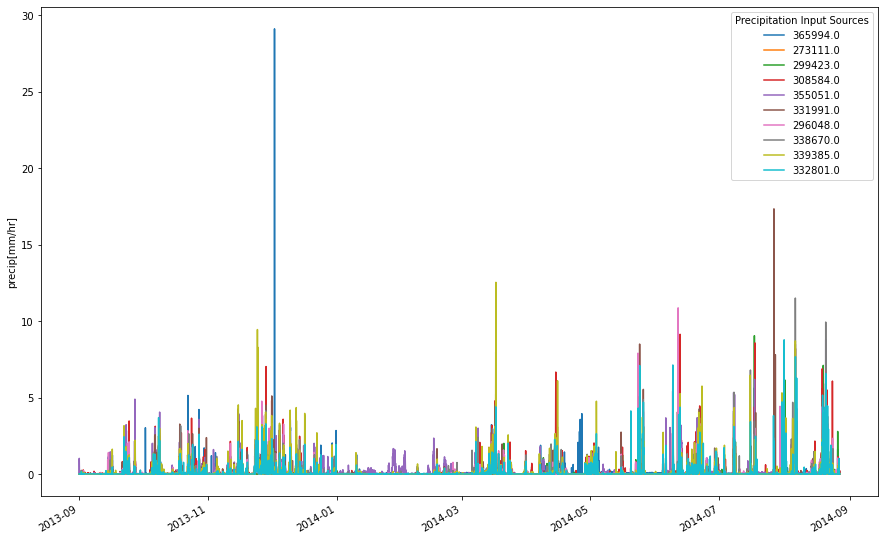

In [20]:
fig, ax = plt.subplots(figsize=(15,10))

for pr in prec:
    t,p = [dt.datetime.utcfromtimestamp(t_) for t_ in pr.ts.time_axis.time_points], pr.ts.values
    ax.plot(t[:-1],p, label=pr.mid_point().x) #uid is empty now, but we reserve for later use
fig.autofmt_xdate()
ax.legend(title="Precipitation Input Sources")
ax.set_ylabel("precip[mm/hr]")

Finally, the next step will take the data from the sources and connect it to our `region_model.region_env` class:

In [21]:
def get_region_environment(sources):
    region_env = api.ARegionEnvironment()
    region_env.temperature = sources["temperature"]
    region_env.precipitation = sources["precipitation"]
    region_env.radiation = sources["radiation"]
    region_env.wind_speed = sources["wind_speed"]
    region_env.rel_hum = sources["relative_humidity"]
    return region_env

region_model.region_env = get_region_environment(sources)

And now our forcing data is connected to the `region_model`. We are *almost* ready to run a simulation. There is just one more step. We've connected the sources to the model, but remember that Shyft is a distributed modeling framework, and we've connected point data sources (in this case). So we need to get the data from the observed *points* to each cell. This is done through interpolation.

### Shyft Interpolation
In Shyft there are predefined routines for interpolation. In the `interp_config` class below one quickly recognizes the same input source type keywords that are used as keys to the `params` dictionary. `params` is simply a dictionary of dictionaries which contains the parameters used by the interpolation model that is specific for each source type.

In [22]:
from shyft.hydrology.repository.interpolation_parameter_repository import InterpolationParameterRepository

class interp_config(object):
    """ a simple class to provide the interpolation parameters """

    def __init__(self):
        
        self.interp_params = {'precipitation': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10,
           'scale_factor': 1.02}},
         'radiation': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}},
         'relative_humidity': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}},
         'temperature': {'method': 'btk',
          'params': {'nug': 0.5,
           'range': 200000.0,
           'sill': 25.0,
           'temperature_gradient': -0.6,
           'temperature_gradient_sd': 0.25,
           'zscale': 20.0}},
         'wind_speed': {'method': 'idw',
          'params': {'distance_measure_factor': 1.0,
           'max_distance': 600000.0,
           'max_members': 10}}}

    def interpolation_parameters(self):
        return self.interp_params

ip_conf = interp_config()
ip_repo = InterpolationParameterRepository(ip_conf)

region_model.interpolation_parameter = ip_repo.get_parameters(0) #just a '0' for now

The next step is to set the intial states of the model using our last repository. This one, the `GeneratedStateRepository` will set empty default values.

Now we are nearly ready to conduct a simulation. We just need to run a few methods to prepare the model and cells for the simulation. The region_model has a method called `initalize_cell_environment` that takes a `time_axis` type as input. We defined the `time_axis` above, so now we'll use it to initialize the model. At the same time, we'll set the initial_state. Then we can actually run a simulation!

In [23]:
from shyft.hydrology.repository.generated_state_repository import GeneratedStateRepository

init_values = {'gs': {'acc_melt': 0.0,
   'albedo': 0.65,
   'alpha': 6.25,
   'iso_pot_energy': 0.0,
   'lwc': 0.1,
   'sdc_melt_mean': 0.0,
   'surface_heat': 30000.0,
   'temp_swe': 0.0},
  'kirchner': {'q': 0.01}}

   
state_generator = GeneratedStateRepository(region_model)#, init_values=init_values)

# we need the state_repository to have the same size as the model
#state_repo.n = region_model.size()
# there is only 1 state (indexed '0')
s0 = state_generator.get_state(0)
not_applied_list=region_model.state.apply_state(  # apply state set the current state according to arguments
    cell_id_state_vector=s0,  # ok, easy to get
    cids=[] # empty means apply all, if we wanted to only apply state for specific catchment-ids, this is where to put them
)
assert len(not_applied_list)==0, 'Ensure all states was matched and applied to the model'
region_model.initial_state=region_model.current_state  # now we stash the current state to the initial state

### Conduct the simulation
We now have a `region_model` that is ready for simulation. As we discussed before, we still need to get the data from our point observations interpolated to the cells, and we need to get the `env_ts` of each cell populated. But all the machinery is now in place to make this happen. 

To summarize, we've created:

* `region_repo`, a region repository that contains information related to region of simulation and the model to be used in the simulation. From this we get a `region_model`
* `geots_repo`, a geo-timeseries repository that provides a mechanism to pull the data we require from our 'sources'.
* `time_axis`, created from the TimeAxisFixedDeltaT class of `shyft` to provide the period of simulation.
* `ip_repo`, an interpolation repository which provides all the required parameters for interpolating our data to the distributed cells -- following variable specific protocols/models.
* `state_repo`, a `GeneratedStateRepository` used to provide our simulation an initial state.

The next step is simply to initialize the cell environment and run the interpolation. As a practive, before simulation we reset to the initial state (we're there already, but it is something you have to do before a new simulation), and then run the cells. First we'll initialize the cell environment:


In [24]:
region_model.initialize_cell_environment(ta_1)


As a habit, we have a quick "sanity check" function to see if the model is runnable. Itis recommended to have this function when you create 'run scripts'.

In [25]:
def runnable(reg_mod):
    """ returns True if model is properly configured 
    **note** this is specific depending on your model's input data requirements """
    return all((reg_mod.initial_state.size() > 0, reg_mod.time_axis.size() > 0,
                   all([len(getattr(reg_mod.region_env, attr)) > 0 for attr in
                    ("temperature", "wind_speed", "precipitation", "rel_hum", "radiation")])))

In [26]:
# run the model, e.g. as you may configure it in a script:
if runnable(region_model):
    
    region_model.interpolate(region_model.interpolation_parameter, region_model.region_env)
    region_model.revert_to_initial_state()
    region_model.run_cells()
else:
    print('Something wrong with model configuration.')


    

Okay, so the simulation was run. Now we may be interested in looking at some of the output. We'll take a brief summary glance in the next section, and save a deeper dive into the simulation results for another notebook.


## 3. Simulation results

The first step will be simply to look at the discharge results for each subcatchment within our simulation domain. For simplicity, we can use a `pandas.DataFrame` to collect the data from each catchment.

Text(0, 0.5, 'discharge [m3 s-1]')

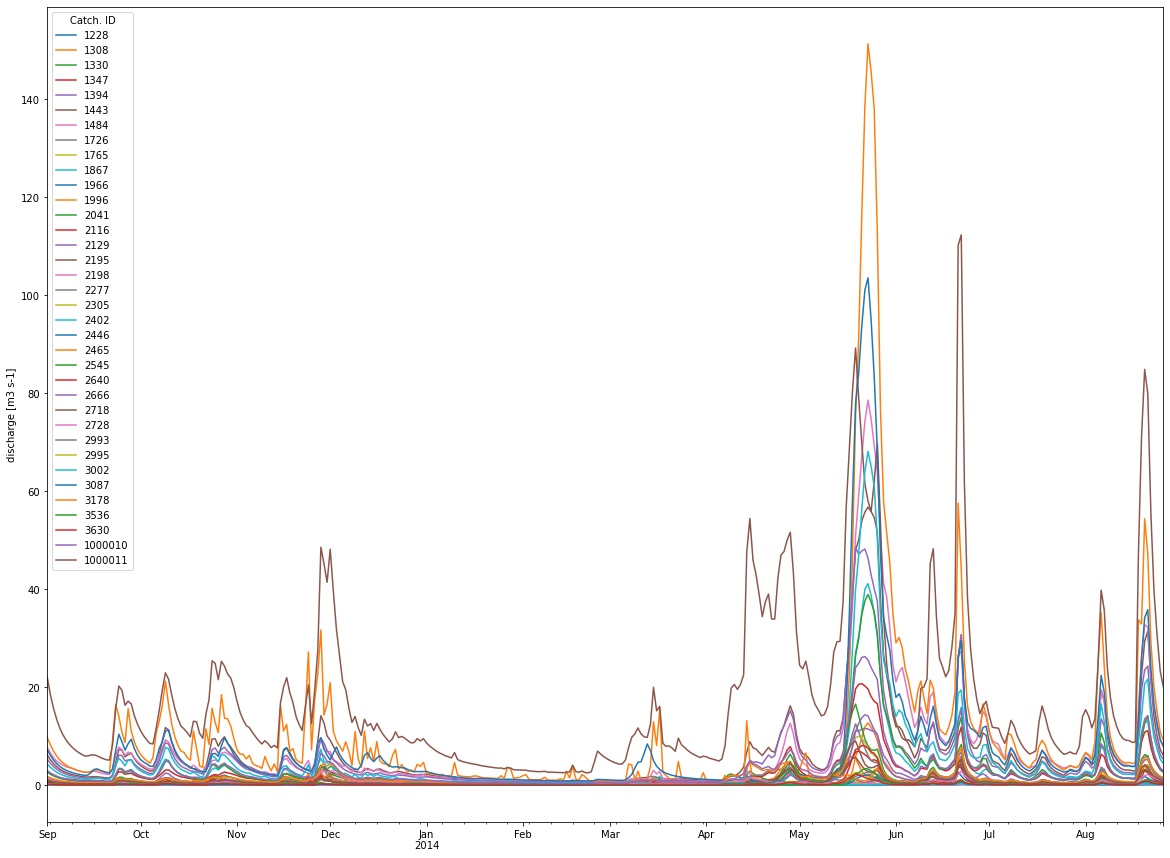

In [28]:
# Here we are going to extact data from the simulation.
# We start by creating a list to hold discharge for each of the subcatchments.
# Then we'll get the data from the region_model object

# mapping of internal catch ID to catchment
catchment_id_map = region_model.catchment_id_map 

# First get the time-axis which we'll use as the index for the data frame
ta = region_model.time_axis
# and convert it to datetimes
timestamps = [ ta.time(i) for i in range(0, ta.n)]
#print(timestamps)
index = [dt.datetime.utcfromtimestamp(p.seconds) for p in timestamps]

# Now we'll add all the discharge series for each catchment 
data = {}
for cid in catchment_id_map:
    # get the discharge time series for the subcatchment
    q_ts = region_model.statistics.discharge([int(cid)])
    data[cid] = q_ts.values.to_numpy()

df = pd.DataFrame(data, index=index)
# we can simply use:
ax = df.plot(figsize=(20,15))
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

Okay, that was simple. Let's look at the timeseries in some individual cells. The following is a bit of a contrived example, but it shows some aspects of the api. We'll plot the temperature series of all the cells in one sub-catchment, and color them by elevation. This doesn't necessarily show anything about the simulation, per se, but rather results from the interpolation step.

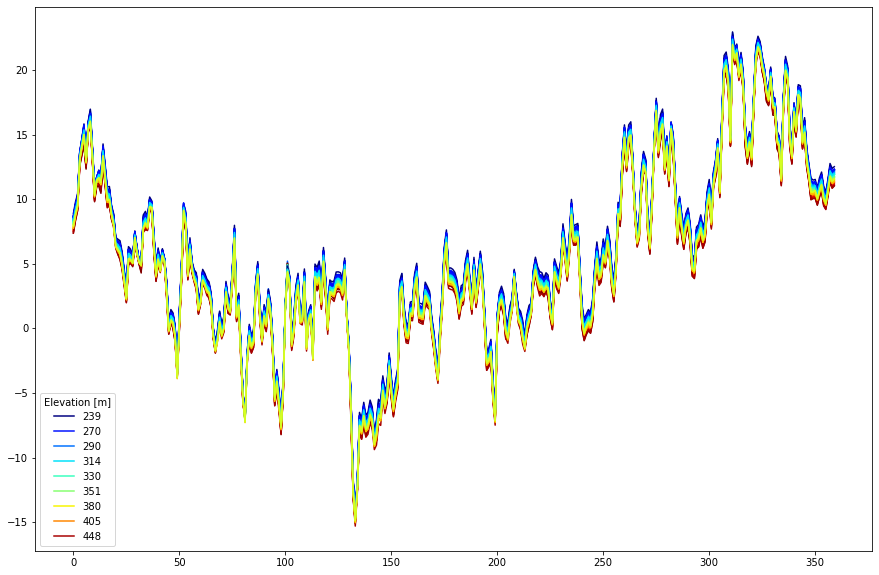

In [29]:
from matplotlib.cm import jet as jet
from matplotlib.colors import Normalize

# get all the cells for one sub-catchment with 'id' == 1228
c1228 = [c for c in region_model.cells if c.geo.catchment_id() == 1228]

# for plotting, create an mpl normalizer based on min,max elevation
elv = [c.geo.mid_point().z for c in c1228]
norm = Normalize(min(elv), max(elv))

#plot with line color a function of elevation
fig, ax = plt.subplots(figsize=(15,10))

# here we are cycling through each of the cells in c1228
for dat,elv in zip([c.env_ts.temperature.values for c in c1228], [c.mid_point().z for c in c1228]):
    ax.plot(dat, color=jet(norm(elv)), label=int(elv))
    
    
# the following is just to plot the legend entries and not related to Shyft
handles, labels = ax.get_legend_handles_labels()

# sort by labels
import operator
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

# show legend, but only every fifth entry
ax.legend(handles2[::5], labels2[::5], title='Elevation [m]')

As we would expect from the temperature kriging method, we should find higher elevations have colder temperatures. As an exercise you could explore this relationship using a scatter plot.

Now we're going to create a function that will read initial states from the `initial_state_repo`. In practice, this is already done by the `ConfgiSimulator`, but to demonstrate lower level functions, we'll reset the states of our `region_model`:

In [30]:
state_generator.find_state?

In [31]:
# create a function to reaad the states from the state repository
def get_init_state_from_repo(initial_state_repo_, region_model_id_=None, timestamp=None):
    state_id = 0
    if hasattr(initial_state_repo_, 'n'):  # No stored state, generated on-the-fly
        initial_state_repo_.n = region_model.size()
    else:
        states = initial_state_repo_.find_state(
            region_model_id_criteria=region_model_id_,
            utc_timestamp_criteria=timestamp)
        if len(states) > 0:
            state_id = states[0].state_id  # most_recent_state i.e. <= start time
        else:
            raise Exception('No initial state matching criteria.')
    return initial_state_repo_.get_state(state_id)
 
init_state = get_init_state_from_repo(state_generator, timestamp=region_model.time_axis.start)


Don't worry too much about the function for now, but do take note of the `init_state` object that we created. This is another container, this time it is a class that contains `PTGSKStateWithId` objects, which are specific to the model stack implemented in the simulation (in this case `PTGSK`). If we explore an individual state object, we'll see `init_state` contains, for each cell in our simulation, the state variables for each 'method' of the method stack.

Let's look more closely:

In [33]:
def print_pub_attr(obj):
    #only public attributes
    print(f'{obj.__class__.__name__}:\t',[attr for attr in dir(obj) if attr[0] != '_']) 
    
print(len(init_state))
init_state_cell0 = init_state[0] 
# the identifier
print_pub_attr(init_state_cell0.id)
# gam snow states
print_pub_attr(init_state_cell0.state.gs)

#init_state_cell0.kirchner states
print_pub_attr(init_state_cell0.state.kirchner)


4650
CellStateId:	 ['area', 'cid', 'x', 'y']
GammaSnowState:	 ['acc_melt', 'albedo', 'alpha', 'iso_pot_energy', 'lwc', 'sdc_melt_mean', 'surface_heat', 'temp_swe']
KirchnerState:	 ['q']


#### Summary
We have now explored the `region_model` and looked at how to instantiate a `region_model` by using a `api.ARegionEnvironment`, containing a collection of timeseries sources, and passing an `api.InterpolationParameter` class containing the parameters to use for the data interpolation algorithms. The interpolation step "populated" our cells with data from the point sources.

The cells each contain all the information related to the simulation (their own timeseries, `env_ts`; their own model parameters, `parameter`; and other attributes and methods). In future tutorials we'll work with the cells indivdual "resource collector" (`.rc`) and "state collector" (`.sc`) attributes.



